In [ ]:
!pip install --upgrade tensorflow > /dev/null
!pip install tf-quant-finance > /dev/null
!pip install QuantLib-Python > /dev/null

La integral definida de seno(x) de 0 a pi es 2.0128797873768525


Text(0.5, 0, 'Areas')

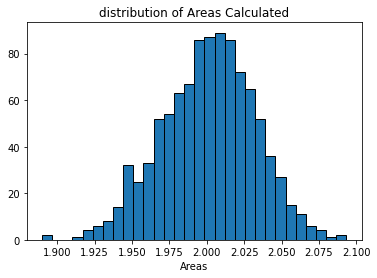

In [ ]:
from scipy import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
# vamos a establecer
# la funcion que queremos integrar 1
# 2. los limites de la integracion que buscamos
# 3. un number generator random
# 4. un loop via la ecuacion MC
a=0
b= np.pi # a y b limites de la integracion
N = 1000 # cantidad de puntos
xrand = random.uniform(a,b,N) # numeros aleatorios del intervalo
# vamos a definir la funcion que queremos integrar
def func(x):
  return np.sin(x)
# Evaluamos la funcion en el intervalo con los puntos de la muestra 
integral = 0.0
for i in range(N):
  integral += func(xrand[i]) # evaluamos la funcion en cada punto
# Luego necesitamos escalar este resultado por B-A sobre N. 
answer = (b-a)/float(N) * integral 
print("La integral definida de seno(x) de 0 a pi es", answer)
areas =[]

for i in range(N):
  xrand = random.uniform(a,b,N)
  integral = 0.0
  for i in range(N):
    integral += func(xrand[i]) 
  answer = (b-a)/float(N) * integral 
  areas.append(answer)

plt.title("distribution of Areas Calculated")
plt.hist(areas,bins=30,ec="black")
plt.xlabel("Areas")


# pricing europea Monte Carlo Python

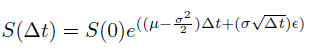

In [ ]:
import numpy as np
import math
# vamos a crear una clase para organizar mejor el codigo, que la vamos a usar para opciones europeas y barrera
class ProcesoEstocastico:
    def time_step(self):
        # Proceso brownianno es ~N(0, delta_t), np.random.normal toma el mean y volatility (raiz delta_t)
        dW = np.random.normal(0, math.sqrt(self.delta_t))
        dS = self.drift*self.current_asset_price*self.delta_t + self.asset_volatility*self.current_asset_price*dW
        self.asset_prices.append(self.current_asset_price + dS) # agregamos al array
        # el actual precio seria el actual + diferencial de S (siguiente timestep)
        self.current_asset_price = self.current_asset_price + dS

    def __init__(self, asset_price, drift, delta_t, asset_volatility):
        self.current_asset_price = asset_price
        self.asset_prices = []
        self.asset_prices.append(asset_price)
        self.drift = drift
        self.delta_t = delta_t
        self.asset_volatility = asset_volatility
        self.procesos_estocasticos = None
class EuroCall:

    def __init__(self, strike):
        self.strike = strike

class EuroCallPricing:

    def __init__(self, EuroCall, n_simulations, S0, drift, delta_t, asset_volatility, time_to_expiration, risk_free_rate):
        # creamos una lista de procesos estocasticos
        procesos_estocasticos = []
        # Generamos un proceso estocastico para cada simulacion
        for i in range(n_simulations):
            procesos_estocasticos.append(ProcesoEstocastico(S0, drift, delta_t, asset_volatility)) 
        
        # creamos los pasos requeridos en tiempo para la simulacion, creando un time_step in el proceso estocastico
        # si aun es mayor a 0, sontinua haciendo n timestemp por cada proceso estocastico que generamos
        for proceso_esticastico in procesos_estocasticos:
            tte = time_to_expiration
            # en vez de definir un timesteps, vamos incrementando delta_t,hasta que la suma de delta_t sea igual al tiempo de expiraicon
            while((tte-proceso_esticastico.delta_t) > 0):
                tte = tte - proceso_esticastico.delta_t
                # Hacemos time_step. O sea generamos un incremento dS, y lo sumamos a la sucesion de precios del proceso estocastico
                proceso_esticastico.time_step()

        #calculamos los payoffs
        payoffs = []
        # ahora para cada proceso estocastico determinamos el payoff
        for proceso_esticastico in procesos_estocasticos:
            payoff = proceso_esticastico.asset_prices[len(proceso_esticastico.asset_prices)-1] - EuroCall.strike
            # el payoff es el ultimo precio  menos el strike
            z = max(payoff,0)
            payoffs.append(z)
          
        # ahora promediamos los payoff 
        payoff_avg = np.mean(payoffs)
        # e**(-r*t)
        e_rt = math.exp(-time_to_expiration*risk_free_rate)
        self.price = payoff_avg*e_rt
        self.procesos_estocasticos = procesos_estocasticos
    def plot(self):
      for proceso_esticastico in self.procesos_estocasticos:
        plt.plot(proceso_esticastico.asset_prices)
      plt.show()


Definimos los parametros de la opcion europea:

- Strike: 296
- Spot 295
- Sigma o volatility: 0.2435
- Risk Free: 0.0017
- Time to expiration: (39 days). Para el caso de QuantLib se especifican en un rango de fechas y no via un decimal (39/365)
- delta t: 1/100.

In [ ]:
def parametros():
  return {"spot":295,"r":0.0017,"sigma":0.2435,"strike":296,"samples":20000,"timestep":365,"time_to_expire":39/365}

In [ ]:
params=parametros()

In [ ]:
import time
t = time.time()
eu_option = EuroCallPricing(EuroCall=EuroCall(params["strike"]), n_simulations=params["samples"],S0=params["spot"],drift= 0, delta_t=1/params["timestep"],
                               asset_volatility= params["sigma"], time_to_expiration=params["time_to_expire"],  risk_free_rate=params["r"])
print('Monte Carlo Euro Call Price: ', eu_option.price)
time_ = time.time()-t
print("time",time_, "sec")
times=[]
times.append(["European Call","Monte Carlo Python",time_,params["samples"],eu_option.price])

Monte Carlo Euro Call Price:  8.590034619362216
time 3.567714214324951 sec


In [ ]:
eu_option.plot()

# Pricing Europea Monte carlo con QuantLib

In [ ]:
params=parametros()
params

{'r': 0.0017,
 'samples': 20000,
 'sigma': 0.2435,
 'spot': 295,
 'strike': 296,
 'time_to_expire': 0.10684931506849316,
 'timestep': 365}

In [ ]:


# PRICING CON QUANTLIB
import QuantLib as ql
import time
num_samples = params["samples"] 
num_timesteps = params["timestep"]  
calculation_date = ql.Date(18, 11, 2021)
maturity_date = ql.Date(27, 12, 2021) # una diferencia de 39 dias
day_count = ql.Thirty365()
calendar = ql.NullCalendar()
option_type = ql.Option.Call

ql.Settings.instance().evaluationDate = calculation_date
payoff = ql.PlainVanillaPayoff(option_type, params["strike"])

eu_exercise = ql.EuropeanExercise(maturity_date)
european_option_ql = ql.VanillaOption(payoff, eu_exercise)

flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, params["r"], day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar,
                        ql.QuoteHandle(ql.SimpleQuote(params["sigma"])), day_count)
)

spot_handle = ql.QuoteHandle(ql.SimpleQuote(params["spot"] ))
black_scholes_process = ql.BlackScholesProcess(spot_handle,
                                      flat_ts,
                                      flat_vol_ts)

# Computa el MonteCarlo pseudo-random
engine = ql.MCEuropeanEngine(black_scholes_process, "PseudoRandom",
                             timeSteps=num_timesteps,
                             requiredSamples=num_samples,
                             seed=42)
european_option_ql.setPricingEngine(engine)
# Price
t = time.time()
price_ql = european_option_ql.NPV()
print("Precio MC QuantLib",price_ql)
time_price_ql = time.time() - t
times.append(["European Call","Monte Carlo QuantLib",time_price_ql,num_samples,price_ql])
print("Time (seconds) del pricing Quantlib: ", time_price_ql)


Precio MC QuantLib 8.880990400138803
Time (seconds) del pricing Quantlib:  4.99634313583374


In [ ]:
params=parametros()
params

{'r': 0.0017,
 'samples': 20000,
 'sigma': 0.2435,
 'spot': 295,
 'strike': 296,
 'time_to_expire': 0.10684931506849316,
 'timestep': 365}

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
def pricing_tf_option(params):

  
  normal_=(tfp.distributions.Normal(
      loc=0, scale=1, validate_args=False, allow_nan_stats=True, name='Normal'
  ))
  time_delta = time_to_expire / params["timestep"]
  num_samples=params["samples"]
  x=(r - 0.5 * params["sigma"] ** 2) * time_delta + params["sigma"] * tf.sqrt(time_delta) * normal_.sample(sample_shape=(params["samples"],params["timestep"]),seed=1)
  e_rt = tf.exp(x)
  precios_simulados = black_scholes=stock_price * tf.math.cumprod(e_rt, axis = 1)
  payout=tf.nn.relu(precios_simulados[:,-1]-strike_price)
  option_price_tf = (tf.exp(-risk_free*time_to_expr) * tf.reduce_mean(payout,0))
  return option_price_tf
  #plt.plot(np.transpose(precios_simulados))
  #plt.show()

In [ ]:
pricing_tf_option_function=tf.function(pricing_tf_option)
price_=pricing_tf_option_function(params)

In [ ]:

t = time.time()
price_=pricing_tf_option_function(params)
time_tf = time.time()-t
print(time_tf,"sec")
print(price_)
times.append(["European Call","Monte Carlo Tensorflow2",time_tf,num_samples,price_.numpy()])


0.19769620895385742 sec
tf.Tensor(8.79943, shape=(), dtype=float32)


## Resultado final - Comparativa Python vs QuantLib vs Tensorflow2

In [ ]:
times_european=times
import pandas as pd
pd.DataFrame(times_european,columns=["Option","Method","Execution Time","N simulations","price"])


,Option,Method,Execution Time,N simulations,price
0,European Call,Monte Carlo Python,3.567714,20000,8.590035
1,European Call,Monte Carlo QuantLib,4.996343,20000,8.880990
2,European Call,Monte Carlo Tensorflow2,0.197696,20000,8.799430


QuantLib Stochastic Process 

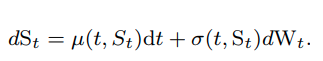

Quantlib BlackScholes Process

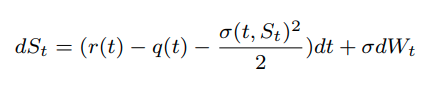

Fuente: https://www.quantlib.org/slides/dima-ql-intro-2.pdf


# BARRIER OPTIONS

Vamos a utilizar los siguientes parametros para el pricing de las opciones barrera:
- Spot: 100
- risk free: 1%
- volatility o sigma: 0.15
- strike: 20
- barrier: 95
- samples: 20000 (cuantas simulaciones haremos en Monte Carlo)
- timestep: 365 (nuestro T vamos a dividirlo en 365 partes, es decir, delta t: 1/365.
- Time to Expire: 1 (1 año)


In [ ]:
def parametros():
  return {"spot":100,"r":0.01,"sigma":0.15,"strike":20,"barrier":95,"samples":20000,"timestep":365,"time_to_expire":1}

In [ ]:
def quantlib_barrier_downIn(spot_price=100,r=0.01,sigma_value=0.3,strike=60,barrier=70,samples=20000,timestep=100,calculation_date=None,maturity_date=None):
  # Opcion Barrera Down And In 
  ql.Settings.instance().evaluationDate = calculation_date # indicamos la fecha de calculo a la enviada por parametro
  exercise_ = ql.EuropeanExercise(maturity_date) # la fecha de maturity
  spot = ql.SimpleQuote(spot_price)
  r = ql.SimpleQuote(r) # Risk-free 
  sigma = ql.SimpleQuote(sigma_value) # Sigma o Implied Volatility 
  day_count = ql.Thirty365() # Notese que aca hacemos 365 dias ya que los otros metodos no se programo un calendario especifico
  calendar = ql.NullCalendar() # aca indicamos que no contemple determinados feriados
  payoff_ = ql.PlainVanillaPayoff(ql.Option.Call,strike)
  # las opciones barrera pueden tener un rabate, un reembolso que se le paga a al comprador de la opcion si la opcion no se puede ejercer
  option = ql.BarrierOption(barrierType=ql.Barrier.DownIn, barrier=barrier, rebate=0.0, payoff=payoff_, 
                                exercise=exercise_)
  
  riskFreeCurve = ql.FlatForward(0, calendar, ql.QuoteHandle(r), day_count)
  volatility = ql.BlackConstantVol(0, calendar, ql.QuoteHandle(sigma), day_count)
  
  #
  process = ql.BlackScholesProcess(ql.QuoteHandle(spot), ql.YieldTermStructureHandle(riskFreeCurve), ql.BlackVolTermStructureHandle(volatility))
  #process = ql.GeometricBrownianMotionProcess(initialValue=spot_price,mu=0,sigma=sigma_value)
  # El metodo MCBarrierEngine pide como parametro un proceso BlackScholesProcess
  rng = "pseudorandom" # usamos low-discrepancy en vez de "pseudorandom" lowdiscrepancy
  engine=ql.MCBarrierEngine(process=process,traits=rng,timeSteps=timestep,requiredSamples=samples)
  option.setPricingEngine(engine)
  return option.NPV()

In [ ]:
# En quantlib no se especifica el time to expire, por ello es que le pasamos las fechas de calculo y de maturity
# El engine de Monte Carlo para las opciones barrera pide como parametro un proceso BlackScholesProcess. Por lo que la comparación 
# no pueda llegar a ser exacta
times=[]
t=time.time()
params = parametros()
price=quantlib_barrier_downIn(spot_price=params["spot"],
                              r=params["r"],
                              sigma_value=params["sigma"],
                              strike=params["strike"],
                              barrier=params["barrier"],
                              samples=params["samples"],
                              timestep=params["timestep"],
                              calculation_date = ql.Date(18, 11, 2021),
                              maturity_date = ql.Date(17, 11, 2022)) #
print("quantlib",price)
times.append(["CallBarrierOptionDownandIn","QuantLib",time.time()-t,num_samples,price])
times

quantlib 54.95773531848535


[['CallBarrierOptionDownandIn',
  'QuantLib',
  5.518125534057617,
  20000,
  54.95773531848535]]

In [ ]:
class BarrierOption:

    def __init__(self, strike, barrier):
        self.strike = strike
        self.barrier = barrier
        self.knocked_in = False
        self.procesos_estocasticos=None
        
class PricerCallBarrierDownIn:

    def __init__(self, barrier_option_downIn, num_samples, initial_asset_price, drift, delta_t, asset_volatility, time_to_expiration, risk_free_rate):
        

        procesos_estocasticos = []
        
        for i in range(num_samples):
            procesos_estocasticos.append(ProcesoEstocastico(initial_asset_price, drift, delta_t, asset_volatility)) 

        for proceso_estocastico in procesos_estocasticos:
            tte = time_to_expiration
            while((tte-proceso_estocastico.delta_t) > 0):
                tte = tte - proceso_estocastico.delta_t
                proceso_estocastico.time_step()
        payoffs = []
        # generamos los movimientos brownianos y ahora compararemos con la barrera
        for proceso_estocastico in procesos_estocasticos:
            for i in range(0, len(proceso_estocastico.asset_prices)):
                if proceso_estocastico.asset_prices[i] <= barrier_option_downIn.barrier:
                    barrier_option_downIn.knocked_in = True
            # Si la barrera fue tocada se calcula el payoff sino su payoff es cero.
            if barrier_option_downIn.knocked_in == True:
                payoff = proceso_estocastico.asset_prices[len(proceso_estocastico.asset_prices)-1] - barrier_option_downIn.strike
                z = max(payoff,0)
                payoffs.append(z)
            if barrier_option_downIn.knocked_in != True:
                payoffs.append(0)
            barrier_option_downIn.knocked_in = False
        self.price = np.average(payoffs)*math.exp(-time_to_expiration*risk_free_rate) # calculo el precio final descontado
        self.procesos_estocasticos = procesos_estocasticos
    def plot(self):
      # este metodo nos ayuda a visualizar el proceso generado
      for proceso_estocastico in self.procesos_estocasticos:
        plt.plot(proceso_estocastico.asset_prices)
      plt.show()

In [ ]:
params = parametros()
params

{'barrier': 95,
 'r': 0.01,
 'samples': 20000,
 'sigma': 0.15,
 'spot': 100,
 'strike': 20,
 'time_to_expire': 1,
 'timestep': 365}

In [ ]:
t=time.time()
option_price=PricerCallBarrierDownIn(BarrierOption(strike=params["strike"], barrier=params["barrier"]), 
                                     num_samples=params["samples"], 
                                     initial_asset_price=params["spot"],
                                     drift=0,
                                     delta_t=1/365,
                                     asset_volatility=params["sigma"], 
                                     time_to_expiration=params["time_to_expire"],
                                     risk_free_rate=params["r"])

print("precio",option_price.price)
times.append(["CallBarrierOptionDownandIn","Python",time.time()-t,params["samples"],option_price.price])

precio 53.742245635554745


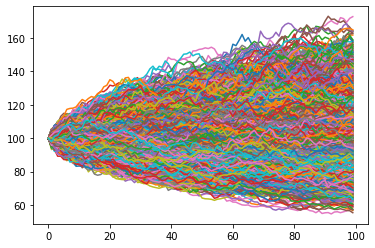

In [ ]:
option_price.plot()

In [ ]:
params=parametros()

En este caso vamos a utilizar Tensorflow2 con Tensorflow Quant Finance (TFF).
TFF trae modelos de generación de procesos incorporados. 
En este caso utilizaremos GeometricBrownianMotion, pero tambien esta disponible Generic Ito Process, Heston, entre otros. 

In [ ]:
import tf_quant_finance as tff 
import numpy as np
@tf.function # indicamos que la siguiente funcion es una funcion tensorflow. Convertimos la funcion python es una funcion de grafos tensorflow
def tf_barrier_option(barrier,risk_free,volatility,num_samples,initial_state,time_to_expire,strike_price):
  # definimos un objeto grometric_bm como un modelo de Geometric Brownian motion
  geometric_bm=tff.models.GeometricBrownianMotion(mean=0,volatility=volatility,dtype=tf.float64)
  # generamos las simulaciones, en eje X 365 puntos. y Generamos "num_samples" caminos. Initial_state es el precio inicial.
  paths=geometric_bm.sample_paths(times=np.linspace(0,1,365),num_samples=num_samples,initial_state=initial_state)
  precios_simulados=paths[:,:,0]
  # definimos una condicion, ¿el valor minimo de cada simulacion es menor igual a la barrera? Es decir, ¿la ha tocado? 
  cond=tf.less_equal(tf.reduce_min(precios_simulados,1),barrier)
  # calculamos los payoffs
  # Si la barrera fue tocada, entonces calculamos max(S_T - K) , sino 0.
  # la funcion ReLu es igual a la funcion max(). Reemplaza valores negativos por cero.
  payoffs=tf.where(cond,tf.nn.relu(precios_simulados[:,-1]-strike_price),tf.zeros_like(precios_simulados[:,-1]))
  # calculamos el precio descontando con e**rt.
  price=tf.math.exp(-tf.constant(risk_free,tf.float64)*time_to_expire)*tf.cast(tf.reduce_mean(payoffs),tf.float64)
  return price,precios_simulados

In [ ]:

price,precios_simulados=tf_barrier_option(barrier=params["barrier"],risk_free=params["r"],volatility=params["sigma"],num_samples=params["samples"],initial_state=params["spot"],
                                 time_to_expire=params["time_to_expire"],strike_price=params["strike"])

In [ ]:
t = time.time()
price,precios_simulados=tf_barrier_option(barrier=params["barrier"],risk_free=params["r"],volatility=params["sigma"],num_samples=params["samples"],initial_state=params["spot"],
                                 time_to_expire=params["time_to_expire"],strike_price=params["strike"])

times.append(["CallBarrierOptionDownandIn","Tensorflow",time.time()-t,num_samples,price.numpy()])

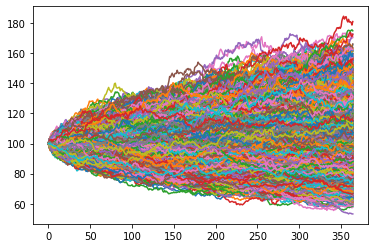

In [ ]:
plt.plot(tf.transpose(precios_simulados))
plt.show()

In [ ]:
import pandas as pd
pd.DataFrame(times,columns=["Option","Method","Execution Time","N simulations","price"])

,Option,Method,Execution Time,N simulations,price
0,CallBarrierOptionDownandIn,QuantLib,5.518126,20000,54.957735
1,CallBarrierOptionDownandIn,Python,30.607119,20000,53.742246
2,CallBarrierOptionDownandIn,Tensorflow,0.814722,20000,54.565328
